---

# 9 Advanced deep learning for computer vision

## 9.1 Three essential computer vision tasks

In [1]:
import os, sys, random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    
    
     # 'My Drive' is the default name of Google Drives
    my_dir = 'drive/My Drive/IS53024B-Artificial-Intelligence/5-DL-for-computer-vision' # CHANGE ME
    os.chdir(my_dir)
    os.listdir()

- *Image classification*: assign one or more labels to an images;
- *Image segmentation*: partition image into different areas (locating categories of bojects), operates on **pixels**;
- *Object detection*: draw rectangles around object.

<!-- ![Chollet three tasks](images/chollet.three-tasks.png) -->
![Chollet three tasks](https://drive.google.com/uc?id=18SbTDySk44UDjf2GyEGf4hh9xAIloYDV)

---

## 9.2 An image segmentation example

Code to download and unzip the data.


### Original address, with corrupted images (see at the bottom of this notebook)
```bash
mkdir oxford-pets
cd oxford-pets
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
```

### New address
```bash
mkdir oxford-pets
git clone https://github.com/ml4py/dataset-iiit-pet oxford-pets/dataset-iiit-pet
```

In [2]:
batch_size = 64
img_size = (200, 200)

base_dir = "oxford-pets" + "/oxford-iiit-pet-new"
input_dir = os.path.join(base_dir, "images/")
target_dir = os.path.join(base_dir, "annotations/trimaps/")

In [3]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

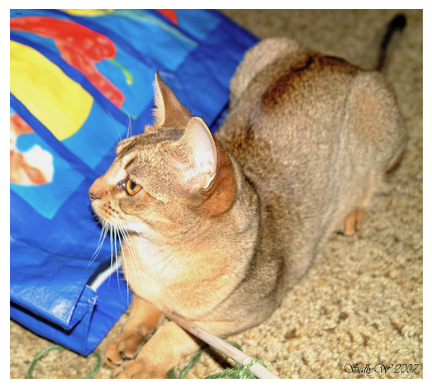

In [4]:
plt.axis("off")
plt.imshow(tf.keras.utils.load_img(input_img_paths[9]))

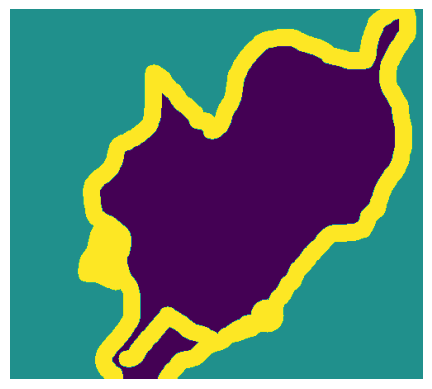

In [5]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = tf.keras.utils.img_to_array(tf.keras.utils.load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [6]:
input_fname_ds = tf.data.Dataset.list_files(f"{input_dir}*.jpg", shuffle=False)
target_fname_ds = tf.data.Dataset.list_files(f"{target_dir}*.png", shuffle=False).filter(
    lambda x : not tf.strings.regex_full_match(x, ".*\/\..*")) # remove files starting with .

main_fname_ds = tf.data.Dataset.zip(
    (input_fname_ds, target_fname_ds)
)

In [7]:
# sanity check, all file names are equal to their targets
sanity = True
if not sanity:
    for f,g in main_fname_ds:
        fstr = f.numpy().decode()
        gstr = g.numpy().decode()
        fs = fstr[fstr.rfind("/"):-3]
        gs = gstr[gstr.rfind("/"):-3]
        if fs != gs:
            print(fs)
            print(gs)

In [8]:
def parse_image(fname):
    """Source: https://www.tensorflow.org/guide/data#decoding_image_data_and_resizing_it"""
    img = tf.io.read_file(fname)
    img = tf.io.decode_jpeg(
        img, channels=3, try_recover_truncated = True,
        acceptable_fraction=1,
    )    
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_size)
    return img

def parse_target(fname):
    img = tf.io.read_file(fname)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.resize(img, img_size)
    return img - 1

def map_func(x, y): 
    return parse_image(x), parse_target(y) # , x, y

processed_ds = main_fname_ds.map(map_func)

In [9]:
# check image and mask
sanity = True
if not sanity:
    for i,t in processed_ds.skip(10):
        print(i.shape)
        print(t.shape)
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(i)
        ax[1].imshow(t * 127)
        break

In [10]:
# shuffle before you batch https://stackoverflow.com/a/50453698
# prefetch: https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options
# complete tutorial: https://www.tensorflow.org/guide/data_performance
# also: https://cs230.stanford.edu/blog/datapipeline/#best-practices
val_steps = 16

                           # ↓ from 1024 onward
train_dataset = processed_ds.skip(batch_size * val_steps)\
                    .shuffle(batch_size * val_steps)\
                    .batch(batch_size, drop_remainder=True)\
                    .prefetch(tf.data.AUTOTUNE)\
                    .repeat()
                        
                         # ↓ the first 1024
val_dataset = processed_ds.take(batch_size * val_steps)\
                    .shuffle(batch_size * val_steps)\
                    .batch(batch_size, drop_remainder=True)\
                    .prefetch(tf.data.AUTOTUNE)\
                    .repeat()

In [16]:
sanity = True
ds = train_dataset # val_dataset
if not sanity:
    for i,t in ds.skip(6):
        print(i.shape)
        print(t.shape)

        fig, ax = plt.subplots(1,2)
        ax[0].imshow(i[0].numpy())
        normalized_array = t[0] * 127
        ax[1].imshow(normalized_array[:, :, 0])
        break

<!-- ![Kaveh, stack overflow](images/deconv/deconv.1.png) -->
![Kaveh, stack overflow](https://drive.google.com/uc?id=1SnOH8oSc-Nm8BnfgBscZ9ZoreU4JFpxN)

<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

<!-- ![Kaveh, stack overflow](images/deconv/deconv.2.png) -->
![Kaveh, stack overflow](https://drive.google.com/uc?id=1WFs76_P33NQgvugVWPPyft_4zfWMhJ_9)


<small>Source: [Kaveh's answer to "In Keras what is the difference between Conv2DTranspose and Conv2D", stack overflow](https://stackoverflow.com/a/68980531)</small>

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

                                   # ↓ backward compatibility with Chollet's code down below
def get_model(img_size, num_classes, tf_dataset=True): 
    inputs = keras.Input(shape=img_size + (3,))
    if not tf_dataset:                        # in Chollet's original setup the rescaling happens here, whereas 
        x = layers.Rescaling(1./255)(inputs)  # tf.image.convert_image_dtype does that for us in the pipeline
    else:
        x = inputs
    
    # shrink input (like an encoder)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    # unshrink input (like a decoder)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 25, 25, 256)       590080

In [12]:
model.compile(
    optimizer="rmsprop", 
    loss="sparse_categorical_crossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(base_dir, "oxford_segmentation.keras"),
        save_best_only=True
    )
]

# to revert back to Chollet's version, follow the comments
history = model.fit(
    train_dataset, # Chollet: train_input_imgs, train_targets,
    epochs=50, 
    steps_per_epoch=(len(input_img_paths) - batch_size * 16)//batch_size, # Not in Chollet! (our tf.dataset is infinite, we must give the number of steps)
    batch_size=batch_size,
    validation_data=val_dataset, #  Chollet: validation_data=(val_input_imgs, val_targets) 
    validation_steps=val_steps, # Not in Chollet (infinite tf.dataset, we provide the steps ourselves)
    callbacks=callbacks,
)

Epoch 1/50


2022-11-10 09:37:57.757891: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-10 09:37:57.757965: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-10 09:37:57.838267: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-11-10 09:37:57.838350: W tensorflow/core/common_runtime/bfc_allocato

99/99 [==============================] - 99s 807ms/step - loss: 4.9685 - val_loss: 0.9047
Epoch 2/50
99/99 [==============================] - 85s 816ms/step - loss: 0.9135 - val_loss: 0.8781
Epoch 3/50
99/99 [==============================] - 87s 830ms/step - loss: 0.8314 - val_loss: 0.7936
Epoch 4/50
99/99 [==============================] - 87s 845ms/step - loss: 0.7689 - val_loss: 0.7688
Epoch 5/50
99/99 [==============================] - 87s 840ms/step - loss: 0.7450 - val_loss: 0.7234
Epoch 6/50
99/99 [==============================] - 87s 843ms/step - loss: 0.6930 - val_loss: 0.7343
Epoch 7/50
99/99 [==============================] - 87s 843ms/step - loss: 0.6598 - val_loss: 0.6479
Epoch 8/50
99/99 [==============================] - 87s 839ms/step - loss: 0.6338 - val_loss: 0.6912
Epoch 9/50
99/99 [==============================] - 87s 842ms/step - loss: 0.6076 - val_loss: 0.5855
Epoch 10/50
99/99 [==============================] - 87s 842ms/step - loss: 0.5776 - val_loss: 0.5613


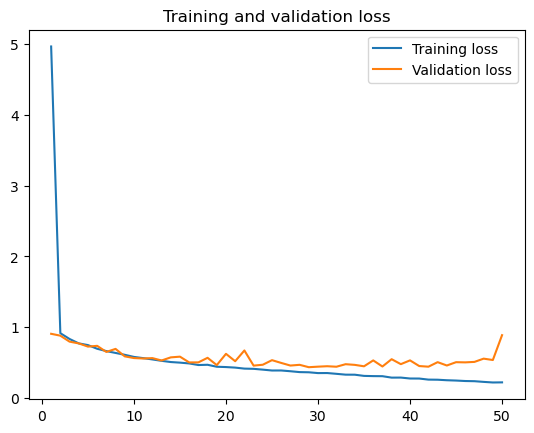

In [13]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [21]:
def display_mask(model, i):
    
    # get image
    # test_image = val_input_imgs[i]             # change to this line in Chollet's original setup
    for img, tgt in val_dataset.skip(i).take(1):
        test_image = img[0]

    # get mask
    pred = model.predict(np.expand_dims(test_image, 0), verbose=0)[0] 
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.axis("off")
    ax1.imshow(tf.keras.utils.array_to_img(test_image))
    ax2.axis("off")
    ax2.imshow(mask)
    plt.show()

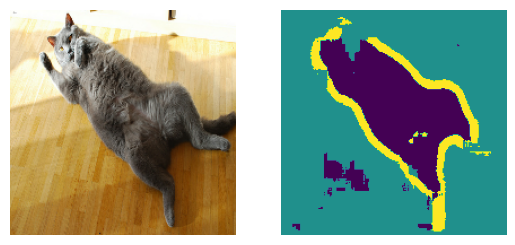

In [22]:
i = 10
display_mask(model, i)

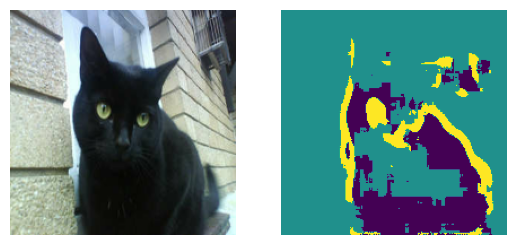

In [23]:
i = 1
display_mask(model, i)

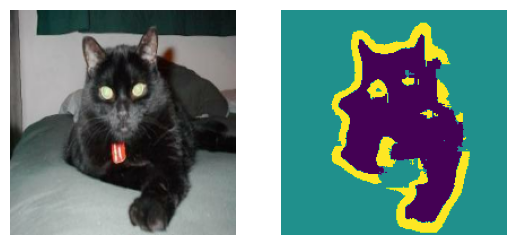

In [24]:
i = 4
display_mask(model, i)

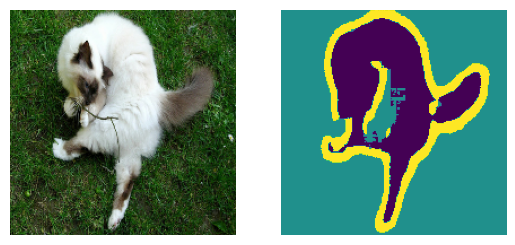

In [25]:
reloaded_model = keras.models.load_model(os.path.join(base_dir, "oxford_segmentation.keras"))
i = 4
display_mask(reloaded_model, i)

---

# Notes on an annoying bug

Various versions of the dataset produced JPEG errors.
```
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
```

Here are some of the attempts I made to rectify that. (In the end the only method that truly worked was to find this cleaned version on GitHub.)

## Using the original code from DLWP

In [8]:
run_orig=False

# trying manually to isolate the corrupt files
# https://github.com/tensorflow/datasets/blob/921c0f86b8eeba863ce0af6523f34ac75d3d7529/tensorflow_datasets/image_classification/cats_vs_dogs.py#L94
if run_orig:
    corrupt_files_indz = [] 
    for i, fname in enumerate(input_img_paths):
        with open(fname, "rb") as fobj:
            if tf.compat.as_bytes("JFIF") not in fobj.peek(10):
                print("Failed for: ", i, fname)
                corrupt_files_indz.append(i)

    input_img_paths = [f for i, f in enumerate(input_img_paths) if i not in corrupt_files_indz]
    target_paths = [f for i, f in enumerate(target_paths) if i not in corrupt_files_indz]            

In [9]:
# using a Linux utility
# https://stackoverflow.com/a/198498
if run_orig:
    !jpeginfo $input_dir/* | grep -i error

In [ ]:
if run_orig:
    !mkdir $base_dir/images_corrupt
    !jpeginfo $input_dir/* | grep -i error | cut -d ' ' -f 1 | xargs -I '{}' mv '{}' $base_dir/images_corrupt

In [40]:
# https://stackoverflow.com/questions/889333/how-to-check-if-a-file-is-a-valid-image-file

if run_orig:
    from PIL import Image

    def verify_jpeg_image(file_path, thorough=False):
        try:
            with Image.open(file_path) as img:
                img.verify()
            if thorough:
                with Image.open(file_path) as img:
                    img.getdata()[0]
        except Exception as e:
            print()
            print(f"error with {file_path}")
            print(e)
            return False
        return True

    for i, fname in enumerate(input_img_paths):
        print(f"{i+1}/{len(input_img_paths)}\r", end="")
        verify_jpeg_image(fname, thorough=True)

In [28]:
run_orig=False
if run_orig:
    img_size = (200, 200)
    num_imgs = len(input_img_paths)

    random.Random(1337).shuffle(input_img_paths)
    random.Random(1337).shuffle(target_paths)

In [28]:
if run_orig:
    def path_to_input_image(path):
        return tf.keras.utils.img_to_array(tf.keras.utils.load_img(path, target_size=img_size))

    def path_to_target(path):
        img = tf.keras.utils.img_to_array(
            tf.keras.utils.load_img(
                path, target_size=img_size, color_mode="grayscale")
        )
        img = img.astype("uint8") - 1
        return img

processing image 0/7390input oxford-pets/images/Abyssinian_1.jpg
float32
[[[29. 37. 26.]
  [30. 38. 27.]
  [31. 39. 28.]
  ...
  [46. 54. 41.]
  [43. 51. 38.]
  [42. 50. 37.]]

 [[29. 37. 26.]
  [31. 39. 28.]
  [33. 41. 30.]
  ...
  [48. 56. 43.]
  [45. 53. 40.]
  [44. 52. 39.]]

 [[30. 38. 27.]
  [32. 40. 29.]
  [33. 41. 30.]
  ...
  [48. 56. 43.]
  [45. 53. 40.]
  [44. 52. 39.]]

 ...

 [[12. 19. 11.]
  [13. 20. 12.]
  [13. 20. 12.]
  ...
  [19. 27. 16.]
  [17. 25. 14.]
  [16. 24. 13.]]

 [[11. 18. 10.]
  [11. 18. 10.]
  [13. 20. 12.]
  ...
  [17. 25. 14.]
  [16. 24. 13.]
  [15. 23. 12.]]

 [[11. 18. 10.]
  [10. 17.  9.]
  [13. 20. 12.]
  ...
  [15. 23. 12.]
  [15. 23. 12.]
  [15. 23. 12.]]]


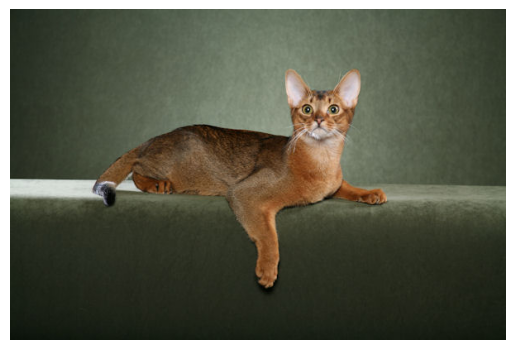


target oxford-pets/annotations/trimaps/Abyssinian_1.png
uint8
[[[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 ...

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]]



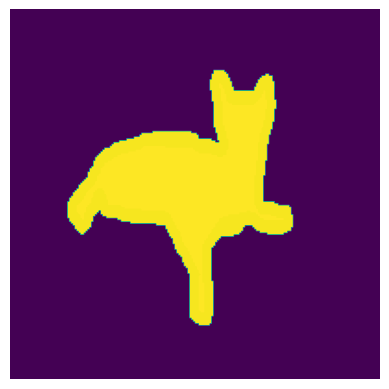

In [72]:
if run_orig:
    input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
    targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

    sanity = True
    for i in range(num_imgs):
        print(f"\rprocessing image {i}/{num_imgs}", end="")
        input_imgs[i] = path_to_input_image(input_img_paths[i])
        targets[i] = path_to_target(target_paths[i])
        if not sanity:
            print('input', input_img_paths[i])
            img = path_to_input_image(input_img_paths[i])
            print(img.dtype)
            print(img)
            plt.axis("off")
            plt.imshow(tf.keras.utils.load_img(input_img_paths[i]))
            plt.show()
            print()
            print('target', target_paths[i])
            tgt = path_to_target(target_paths[i])
            print(tgt.dtype)        
            print(tgt)
            display_target(tgt)
            sanity = True
    print()

In [ ]:
if run_orig:
    num_val_samples = 1000
    train_input_imgs = input_imgs[:-num_val_samples]
    train_targets = targets[:-num_val_samples]
    val_input_imgs = input_imgs[-num_val_samples:]
    val_targets = targets[-num_val_samples:]

---

## Using `TensorFlow Datasets`

In [9]:
run_tfds = False
if run_tfds:
    import tensorflow_datasets as tfds

    (train_ds, test_ds), info = tfds.load(
        name='oxford_iiit_pet',
        split=['train', 'test[:10%]'],
        data_dir="oxford-pets",
        with_info=True,
    )

In [68]:
if run_tfds:
    test_regex = "(Sphynx_158.jpg|Sphynx_159.jpg)"

    for data in train_ds:
        print(data.keys())
        print(data['image'].shape, data['image'].dtype)
        print(data['segmentation_mask'].shape, data['segmentation_mask'].dtype) 
        print(data['file_name'].numpy().decode(), tf.equal(data['file_name'], "Sphynx_158.jpg").numpy())
        print(tf.strings.regex_full_match(data['file_name'], test_regex))
        break

dict_keys(['file_name', 'image', 'label', 'segmentation_mask', 'species'])
(500, 500, 3) <dtype: 'uint8'>
(500, 500, 1) <dtype: 'uint8'>
Sphynx_158.jpg True
tf.Tensor(True, shape=(), dtype=bool)


In [76]:
if run_tfds:

    def parse_image(img):
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, img_size)
        return img

    def parse_target(img):
        img = tf.image.resize(img, img_size)
        return img - 1

    def map_func(data): 
        return parse_image(data['image']), parse_target(data['segmentation_mask'])

    # Issue: how to handle tf.strings in a non-eager setting?
    # There are ways of reverting to plain Python with tf.py_function
    # https://www.tensorflow.org/api_docs/python/tf/py_function
    # https://stackoverflow.com/a/62206594
    def check_img(tf_path):
        return tf_path.numpy().decode() in bad_files

    def wrap_check_img(tf_path):  # turn tf.Tensor to tf.EagerTensor through the wrapper
        return tf.py_function(check_img, [tf_path], [bool])

    # in the end it felt simpler to use a regex:
    
    # bad files listed by one user
    # https://github.com/tensorflow/models/issues/2194#issuecomment-626231696
    bad_files = [
        "beagle_116.jpg", "chihuahua_121.jpg", "Abyssinian_5.jpg", "Egyptian_Mau_14.jpg",
        "Egyptian_Mau_156.jpg", "Egyptian_Mau_186.jpg", "Abyssinian_34", "Egyptian_Mau_139", 
        "Egyptian_Mau_145", "Egyptian_Mau_167", "Egyptian_Mau_177", "Egyptian_Mau_191"
    ]
    bad_files_regex = f"({'|'.join(bad_files)})" # trun filenams into a regex: (f1.jpg|f2.jpg|...)

    processed_ds = train_ds.filter(
        lambda data: not tf.strings.regex_full_match(data['file_name'], bad_files_regex)
    )


Some tests on `bad_files`.

In [89]:
if run_tfds:
    for name in input_img_paths:
        name = name.split("/")[-1]
        print(name)
        break

Abyssinian_1.jpg


In [90]:
if run_tfds:
    for name in bad_files:
        name = f"oxford-pets/images/{name}"
        if name not in input_img_paths:
            print("out", name)
        else:
            print("\tin", name)

	in oxford-pets/images/beagle_116.jpg
	in oxford-pets/images/chihuahua_121.jpg
out oxford-pets/images/Abyssinian_5.jpg
out oxford-pets/images/Egyptian_Mau_14.jpg
out oxford-pets/images/Egyptian_Mau_156.jpg
out oxford-pets/images/Egyptian_Mau_186.jpg
out oxford-pets/images/Abyssinian_34
out oxford-pets/images/Egyptian_Mau_139
out oxford-pets/images/Egyptian_Mau_145
out oxford-pets/images/Egyptian_Mau_167
out oxford-pets/images/Egyptian_Mau_177
out oxford-pets/images/Egyptian_Mau_191


In [80]:
if run_tfds:
    # still running into issues
    for p in processed_ds:
        n =  p['file_name'].numpy().decode()
        if n in bad_files:
            print(n)

Egyptian_Mau_156.jpg
chihuahua_121.jpg
beagle_116.jpg


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Egyptian_Mau_186.jpg
Egyptian_Mau_14.jpg


In [25]:
if run_tfds:
    # verifying if the image type and values work according to our setup
    for img, tgt in processed_ds.take(1):
        print(img.shape, img.dtype, 'value range:', tf.reduce_min(img).numpy(), tf.reduce_max(img).numpy())
        print(tgt.shape, tgt.dtype, 'value range:', tf.reduce_min(tgt).numpy(), tf.reduce_max(tgt).numpy())

(200, 200, 3) <dtype: 'float32'> value range: 0.0 0.8012256
(200, 200, 1) <dtype: 'float32'> value range: 0.0 2.0
